# Pytorch進行圖像分類: 利用MLP和CNN模型

本課程我們將採用在前面課程介紹「私有非結構化資料(水果資料庫)」的Fruits 360資料來進行圖像分類範例。<br>
我們直接讀取此範例處理好的JSON檔案(./dataset/Example_fruit/fruit_train.json)。

1. MLP: Multilayer perceptron (多層感知機)，在深度學習每一層的perceptron則稱為Fully connection。
2. CNN: Convolutional Neural Network (卷積神經網路)

第一步從建立好的JSON檔案(./dataset/Example_fruit/fruit_train.json)，建立pytorch的dataloader。

In [1]:
import torch
import numpy as np
import PIL.Image as Image
import torchvision.transforms.functional as FT
from torchvision import transforms
import json

classnames = ['Apple','Banana','Watermelon']  
with open('./dataset/Example_fruit/fruit_train.json') as jsonfile:
    data_load = json.load(jsonfile)
imagepaths = data_load['imagepaths']
labels = data_load['labels']
print(imagepaths[0:150:20])
print(labels[0:150:20])

mytransform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        ])
def my_collate(batch):
    data, target = list(), list()
    for b in batch:
        data.append(b[0])
        target.append(b[1])
    data = torch.stack(data,dim=0)
    target = torch.stack(target,dim=0)
    return data, target

class MyDataset_Fruits(torch.utils.data.Dataset):
    '''
    load the dataset
    '''
    def __init__(self,transforms):
        with open('./dataset/Example_fruit/fruit_train.json') as jsonfile:
            data_load = json.load(jsonfile)
        self.imList = data_load['imagepaths']
        self.labelList = data_load['labels']
        self.transforms=transforms
        print('number of total data:{}'.format(len(self.imList)))
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
    
        # Convert PIL label image to torch.Tensor
        image = self.transforms(image)
        label = torch.tensor(label)
        return image, label

if __name__ == "__main__":
    mytransform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor()
            ])
    mydataset = MyDataset_Fruits(transforms=mytransform)
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=10, num_workers=0,  collate_fn = my_collate)
    for data in mydata_loader:
        print(data[0].size())
        print(data[1].size())
        break    


['./dataset/Example_fruit/Train\\Apple\\0_100.jpg', './dataset/Example_fruit/Train\\Apple\\250_100.jpg', './dataset/Example_fruit/Train\\Apple\\r_194_100.jpg', './dataset/Example_fruit/Train\\Banana\\192_100.jpg', './dataset/Example_fruit/Train\\Banana\\r2_118_100.jpg', './dataset/Example_fruit/Train\\Watermelon\\20_100.jpg', './dataset/Example_fruit/Train\\Watermelon\\39_100.jpg']
[0, 0, 0, 1, 1, 2, 2]
number of total data:139
torch.Size([10, 3, 28, 28])
torch.Size([10])


## 1. MLP: Multilayer perceptron (多層感知機)。

我們將圖片$3\times28\times28$大小Flatten為2352。<br>

此MLP架構為<br>

輸入層(nodes=2352)<br>
→<br>
Layer1(Fully connection, nodes=512, bias=False) + ReLu<br>
→<br>
Layer2(Fully connection, nodes=256, bias=False) + ReLu<br>
→<br>
Layer3(Fully connection, nodes=128, bias=False) + ReLu<br>
→<br>
輸出層(nodes=3, bias=True) + randomly dropout(0.2)<br>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np

# 步驟0. 是否使用CUDA 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
device = torch.device("cpu")
print(device)
# 步驟1. data loader處理 
mytransform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor()
            ])
dataset_train = MyDataset_Fruits(transforms=mytransform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=30, num_workers=0, shuffle=True, collate_fn = my_collate)

# 步驟2. 模型宣告
class MLP(nn.Module):
    def __init__(self, n_class=3):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(3*28*28, 512, bias=False)
        self.act1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.act2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(256, 128, bias=False)
        self.act3 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(128,n_class)
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,3*28*28)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.droput(x)
        x = self.fc4(x)
        return x
model_mlp = MLP(n_class=3)
print(model_mlp)
model_mlp = model_mlp.to(device)

cpu
number of total data:139
MLP(
  (fc1): Linear(in_features=2352, out_features=512, bias=False)
  (act1): ReLU(inplace=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (act2): ReLU(inplace=True)
  (fc3): Linear(in_features=256, out_features=128, bias=False)
  (act3): ReLU(inplace=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [3]:
    
# initialize the MLP
model_mlp = MLP(n_class=3).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.01)


在訓練的過程中<br>
宣告好的模型必須要用```model.train()```將裡面要訓練的參數打開<br>
例如:<br>
1. 如果有用batch normalization在內，他才會去計算running_mean和running_var
2. dropout機制才會打開。

In [4]:
# 步驟5. 模型開始訓練
total_epoch=100
plt_loss_train=[]
for epoch in range(total_epoch):
    # train
    model_mlp.train()
    train_loss_mlp = 0
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data = torch.squeeze(data)
        data, target = data.to(device), target.to(device)
        # MLP
        optimizer_mlp.zero_grad()
        output_mlp = model_mlp(data)
        loss_mlp = loss(output_mlp,target)  
        train_loss_mlp += loss_mlp
        loss_mlp.backward()
        optimizer_mlp.step()
    train_loss_mlp /= len(dataloader_train.dataset)
    plt_loss_train.append(train_loss_mlp.detach().numpy())
   
    if epoch % 10 ==0:
        print('MLP[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_mlp))
print('MLP[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_mlp))
print('training done.')

MLP[epoch: 1/100], Average loss (Train):0.2086170018
MLP[epoch: 11/100], Average loss (Train):0.0170082506
MLP[epoch: 21/100], Average loss (Train):0.0000022731
MLP[epoch: 31/100], Average loss (Train):0.0000003632
MLP[epoch: 41/100], Average loss (Train):0.0000003407
MLP[epoch: 51/100], Average loss (Train):0.0000000070
MLP[epoch: 61/100], Average loss (Train):0.0000004769
MLP[epoch: 71/100], Average loss (Train):0.0000000182
MLP[epoch: 81/100], Average loss (Train):0.0000026599
MLP[epoch: 91/100], Average loss (Train):0.0000000112
MLP[epoch: 100/100], Average loss (Train):0.0000000007
training done.


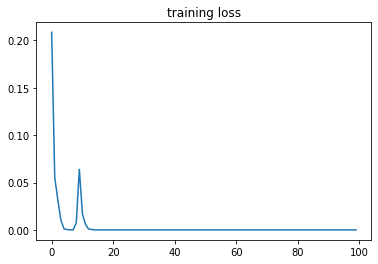

In [5]:
plt.plot(plt_loss_train)
plt.title('training loss')
plt.show()

在測試階段評估模型好壞或是Inference圖片階段，必須要將
模型設定在```model.eval()```，將裡面要訓練參數部分都關掉<br>
例如:<br>
1. 如果有用batch normalization在內，他就不會去計算running_mean和running_var
2. dropout機制會關掉。

為了避免inference過程中去計算梯度(或倒傳遞)，我們習慣在inferenec階段也會用上<br>
```
with torch.no_grad()
```


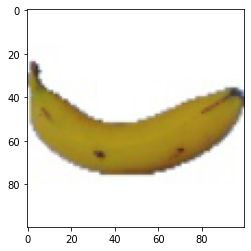

probability for Apple: 0.0000%
probability for Banana: 100.0000%
probability for Watermelon: 0.0000%


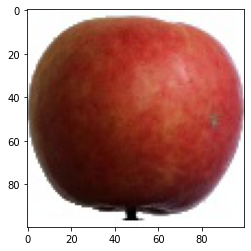

probability for Apple: 100.0000%
probability for Banana: 0.0000%
probability for Watermelon: 0.0000%


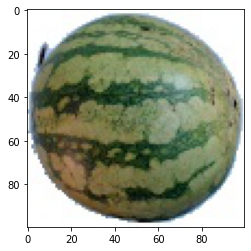

probability for Apple: 0.0041%
probability for Banana: 0.0018%
probability for Watermelon: 99.9941%


In [6]:
mytransform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor()
        ])
model_mlp.eval()  

#114_100.jpg#
#123_100.jpg#
#r_176_100.jpg#
image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
              './dataset/Example_fruit/Test/123_100.jpg',
              './dataset/Example_fruit/Test/r_176_100.jpg']
for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')

    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)

    with torch.no_grad():
        output_mlp = model_mlp(image)
    output_mlp= F.softmax(output_mlp)

    list_class = ['Apple','Banana','Watermelon']
    for i, tmp_out in enumerate(output_mlp[0]):
        print('probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))


## 2. CNN: Convolutional Neural Network (卷積神經網路)

我們將圖片$3\times28\times28$大小Flatten為2352。<br>

此CNN架構為<br>

輸入層(nodes=3)<br>
→<br>
Layer1(Conv2D, channel=32, ks=5, stride=2) + nn.BatchNorm2d + ReLu<br>
→<br>
Layer2(Conv2D, channel=64, ks=5, stride=5) + nn.BatchNorm2d + ReLu<br>
→<br>
Layer3(Conv2D, channel=128, ks=3, stride=1) + nn.BatchNorm2d + ReLu<br>
→<br>
Layer4(Conv2D, channel=64, ks=3, stride=1) + nn.BatchNorm2d + ReLu<br>
→<br>
Layer5(Conv2D, channel=32, ks=3, stride=1) + nn.BatchNorm2d + ReLu<br>
→<br>
輸出層(Fully connection, nodes=3, bias=True)<br>

In [7]:

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self, n_class=3):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(3, 32, 5, 2),
            ConvM(32, 64, 5, 2),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, n_class)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

# initialize the ConvNet
model_cnn = ConvNet(n_class=3).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)



In [8]:
# 步驟5. CNN模型開始訓練
total_epoch=100
plt_loss_train_cnn=[]
for epoch in range(total_epoch):
    # train
    model_cnn.train()
    train_loss_cnn = 0
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        # MLP
#         print(target)
        optimizer_cnn.zero_grad()
        output_cnn = model_cnn(data)
        loss_cnn = loss(output_cnn,target)  
        train_loss_cnn += loss_cnn
        loss_cnn.backward()
        optimizer_cnn.step()
    train_loss_cnn /= len(dataloader_train.dataset)
    plt_loss_train_cnn.append(train_loss_cnn)
   
    if epoch % 10 ==0:
        print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('CNN[epoch: {}/{}], Average loss (Train):{:.10f}'.format(
            epoch+1, total_epoch, train_loss_cnn))
print('training done.')

CNN[epoch: 1/100], Average loss (Train):0.0260009430
CNN[epoch: 11/100], Average loss (Train):0.0000363954
CNN[epoch: 21/100], Average loss (Train):0.0000185523
CNN[epoch: 31/100], Average loss (Train):0.0000130935
CNN[epoch: 41/100], Average loss (Train):0.0000106385
CNN[epoch: 51/100], Average loss (Train):0.0000047163
CNN[epoch: 61/100], Average loss (Train):0.0000060204
CNN[epoch: 71/100], Average loss (Train):0.0000045518
CNN[epoch: 81/100], Average loss (Train):0.0003300716
CNN[epoch: 91/100], Average loss (Train):0.0009055675
CNN[epoch: 100/100], Average loss (Train):0.0001051260
training done.


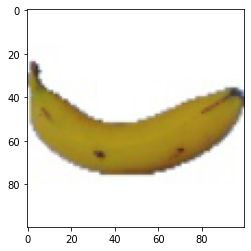

torch.Size([3, 28, 28])
MLP: probability for Apple: 0.0000%
MLP: probability for Banana: 100.0000%
MLP: probability for Watermelon: 0.0000%
**************************************************
CNN: probability for Apple: 0.0048%
CNN: probability for Banana: 99.9943%
CNN: probability for Watermelon: 0.0008%


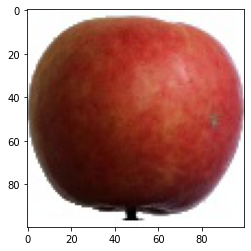

torch.Size([3, 28, 28])
MLP: probability for Apple: 100.0000%
MLP: probability for Banana: 0.0000%
MLP: probability for Watermelon: 0.0000%
**************************************************
CNN: probability for Apple: 99.9893%
CNN: probability for Banana: 0.0100%
CNN: probability for Watermelon: 0.0006%


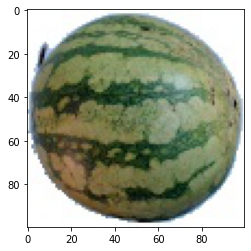

torch.Size([3, 28, 28])
MLP: probability for Apple: 0.0041%
MLP: probability for Banana: 0.0018%
MLP: probability for Watermelon: 99.9941%
**************************************************
CNN: probability for Apple: 0.0068%
CNN: probability for Banana: 0.0002%
CNN: probability for Watermelon: 99.9930%


In [9]:

mytransform = transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor()
        ])
model_mlp.eval()  
model_cnn.eval() 
#114_100.jpg#
#123_100.jpg#
#r_176_100.jpg#
image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
              './dataset/Example_fruit/Test/123_100.jpg',
              './dataset/Example_fruit/Test/r_176_100.jpg']
for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)
    print(image.shape)
    with torch.no_grad():
        output_mlp = model_mlp(torch.squeeze(image))
        output_cnn = model_cnn(torch.unsqueeze(image,dim=0).to(device))
    output_mlp= F.softmax(output_mlp)
    output_cnn= F.softmax(output_cnn)

    list_class = ['Apple','Banana','Watermelon']
    for i, tmp_out in enumerate(output_mlp[0]):
        print('MLP: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))
    print('*'*50)    
    for i, tmp_out in enumerate(output_cnn[0]):
        print('CNN: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))


## 授權 License
<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/3.0/tw/88x31.png" /></a> (CC BY-NC-SA 4.0)<br />本教學課程適用 <a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Attribution-NonCommercial-ShareAlike 4.0 International</a> 授權方式。

※ 轉載、改作、分享請附上以下內容：
 - 如有轉載、改作、分享，請註明出處，source: https://github.com/TommyHuang821/PytorchTutorial
